In [1]:
import pandas as pd 
import numpy as np 

from dython.nominal import associations
from geopy.distance import geodesic

import seaborn as sns 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.stats.diagnostic import lilliefors
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import probplot
import scipy.stats as stats

from sklearn.manifold import MDS,TSNE,Isomap,locally_linear_embedding
from sklearn.decomposition import FastICA,NMF
from sklearn.cluster import KMeans
from sklearn import preprocessing
from skfuzzy.cluster import cmeans

from minisom import MiniSom

In [2]:
plt.ioff()

In [3]:
def silueta(miso):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
    X =miso

    range_n_clusters = [2, 3, 4, 5,6,7,8]

    for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
        centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()


### Cargando bases de datos

In [4]:
df19 = pd.read_csv("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/df19.csv", header = "infer", delimiter = ",")
estaciones = pd.read_csv("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Stations/stations.csv", header = "infer", delimiter = ",")

C:\Users\LENOVO\anaconda3\envs\keras\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df19.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Diff_tiempos,Desplazamiento
0,F,23,10808,35,2019-09-01,0 days 08:05:18,1,2019-09-01,0 days 08:13:53,515,1.093207
1,M,24,10453,280,2019-02-01,0 days 20:54:53,161,2019-02-01,0 days 21:02:51,478,0.998859
2,M,28,8668,154,2019-01-24,0 days 15:21:42,325,2019-01-24,0 days 15:34:53,791,2.056477
3,M,47,10767,280,2019-01-25,0 days 08:40:41,7,2019-01-25,0 days 09:00:28,1187,3.304795
4,F,28,9446,58,2019-01-28,0 days 19:25:31,79,2019-01-28,0 days 19:35:51,620,0.943221


In [6]:
df19.shape

(275609, 11)

In [7]:
tabla = pd.read_csv("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/df_frec.csv", header = "infer", delimiter = ",")
df_distancias = pd.read_csv("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Matrix_distancias.csv", header = "infer", delimiter = ",")

In [8]:
tabla.index += 1

In [9]:
df_distancias.set_index("id", inplace = True)

### Creando mapa

In [10]:
mds=MDS(n_components=2,  metric=True,  n_jobs=-1, random_state=666,dissimilarity="precomputed")
mapa=mds.fit_transform(df_distancias)

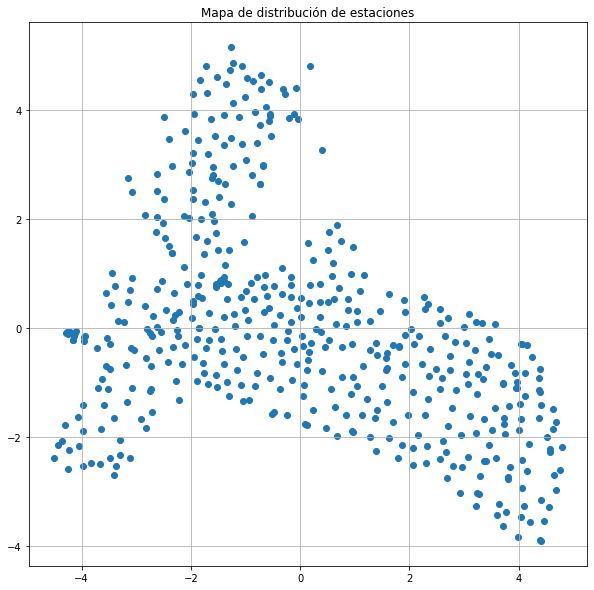

In [11]:
fig = plt.figure(figsize = (10,10))
plt.grid()
plt.scatter(mapa[:,0],mapa[:,1])
plt.title("Mapa de distribución de estaciones")
plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/map plots/Mapa_stations.jpg", bbox_inches ='tight')

plt.close(fig)

## Histogramas, qqplot y test Lilliefors para análisis de variables

#### Edad Usuario

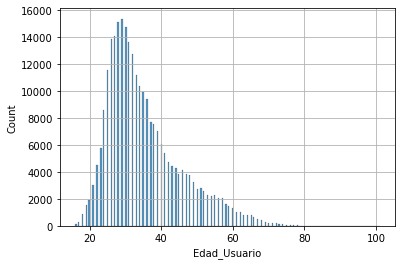

In [12]:
fig = plt.figure()
plt.grid()
sns.histplot(df19["Edad_Usuario"])
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/h_edad.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

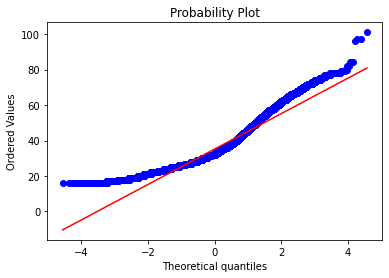

In [13]:
fig, ax = plt.subplots()
probplot(df19["Edad_Usuario"], plot = ax)
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/probplot_normal_edad.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

In [14]:
lilliefors(df19["Edad_Usuario"])

(0.12481232550905585, 0.0009999999999998899)

In [15]:
print(df19["Edad_Usuario"].mean())
print(df19["Edad_Usuario"].std())
print(df19["Edad_Usuario"].quantile(.5))

35.214020587136126
10.407647146076037
32.0


#### Desplazamiento

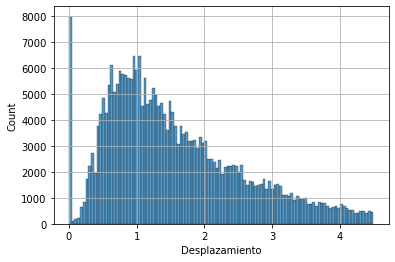

In [16]:
fig = plt.figure()
plt.grid()
sns.histplot(df19["Desplazamiento"])
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/Desplazamiento.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

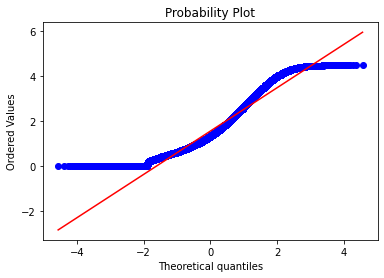

In [17]:
fig, ax = plt.subplots()
probplot(df19["Desplazamiento"], plot = ax)
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/probplot_normal_desplazamiento.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

In [18]:
print(df19["Desplazamiento"].mean())
print(df19["Desplazamiento"].std())
print(df19["Desplazamiento"].quantile(.5))

1.5646187845566992
0.9933755601395212
1.3347202548362092


In [19]:
lilliefors(df19["Desplazamiento"])

(0.09348515980844507, 0.0009999999999998899)

#### Tiempos

In [20]:
shape, loc, scale = stats.lognorm.fit(df19["Diff_tiempos"])

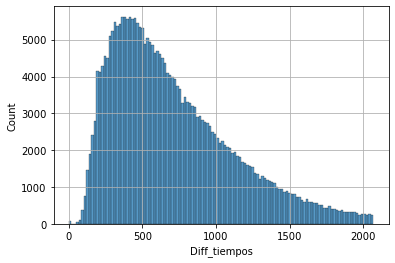

In [21]:
fig = plt.figure()
plt.grid()
sns.histplot(df19["Diff_tiempos"])
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/h_tiempos.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

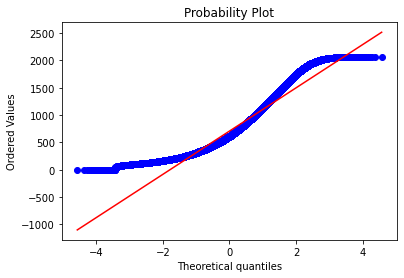

In [22]:
fig, ax = plt.subplots()
probplot(df19["Diff_tiempos"], plot = ax)

plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/probplot_normal_tiempo.jpg", bbox_inches ='tight')
plt.close(fig)

In [23]:
print(df19["Diff_tiempos"].mean())
print(df19["Diff_tiempos"].std())
print(df19["Diff_tiempos"].quantile(.5))

706.998508756971
410.8256611630903
614.0


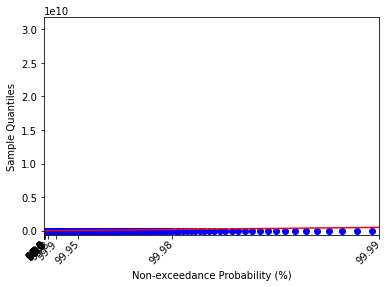

In [24]:
fig, ax = plt.subplots()

lognormal=ProbPlot(df19["Diff_tiempos"], fit = True, dist=stats.lognorm, loc = loc , scale = scale,distargs=(shape,))
lognormal.probplot(line='45', ax=ax)
plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/probplot_lognormal_tiempo.jpg", bbox_inches ='tight')
plt.close(fig)

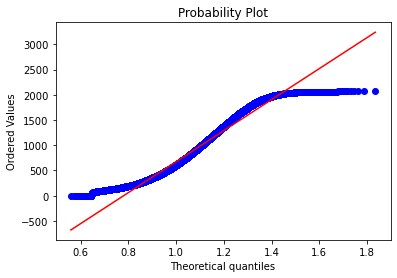

In [25]:
fig, ax = plt.subplots()

probplot(df19["Diff_tiempos"], fit=True, dist=stats.f, sparams=(300,200),plot = ax)

plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/probplot_f.jpg", bbox_inches ='tight')
plt.close(fig)

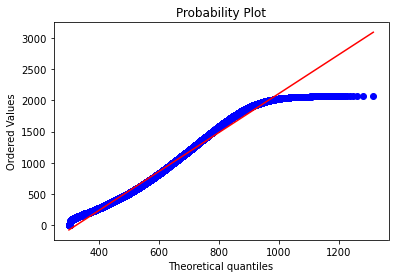

In [26]:
fig, ax = plt.subplots()

probplot(df19["Diff_tiempos"], fit=True, dist=stats.rayleigh, sparams=(300,200),plot = ax)

plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/rayleigh.jpg", bbox_inches ='tight')
plt.close(fig)

In [27]:
lilliefors(df19["Diff_tiempos"])

(0.09076063839421111, 0.0009999999999998899)

#### TIempos para desplazamiento == 0 

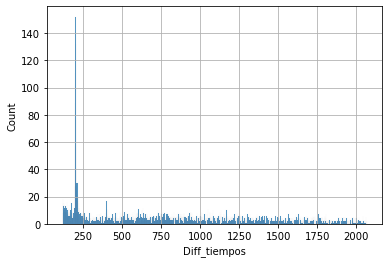

In [28]:
mascara= df19["Desplazamiento"]  == 0
fig = plt.figure()
plt.grid()
sns.histplot(data=df19[mascara], x = "Diff_tiempos", discrete = True)
plt.show()
plt.close(fig)

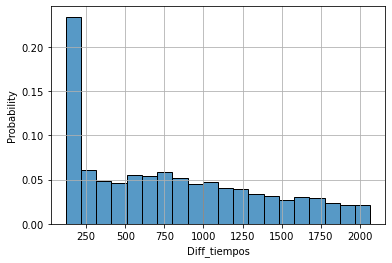

In [29]:
mascara= df19["Desplazamiento"]  == 0
fig = plt.figure()
plt.grid()
sns.histplot(data=df19[mascara],
             x = "Diff_tiempos",
             stat = "probability",)
plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/tiempo_desplazamiento=0.jpg", bbox_inches ='tight')
plt.close(fig)

## Analizando pares de variables

#### Matriz de correlacion

C:\Users\LENOVO\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


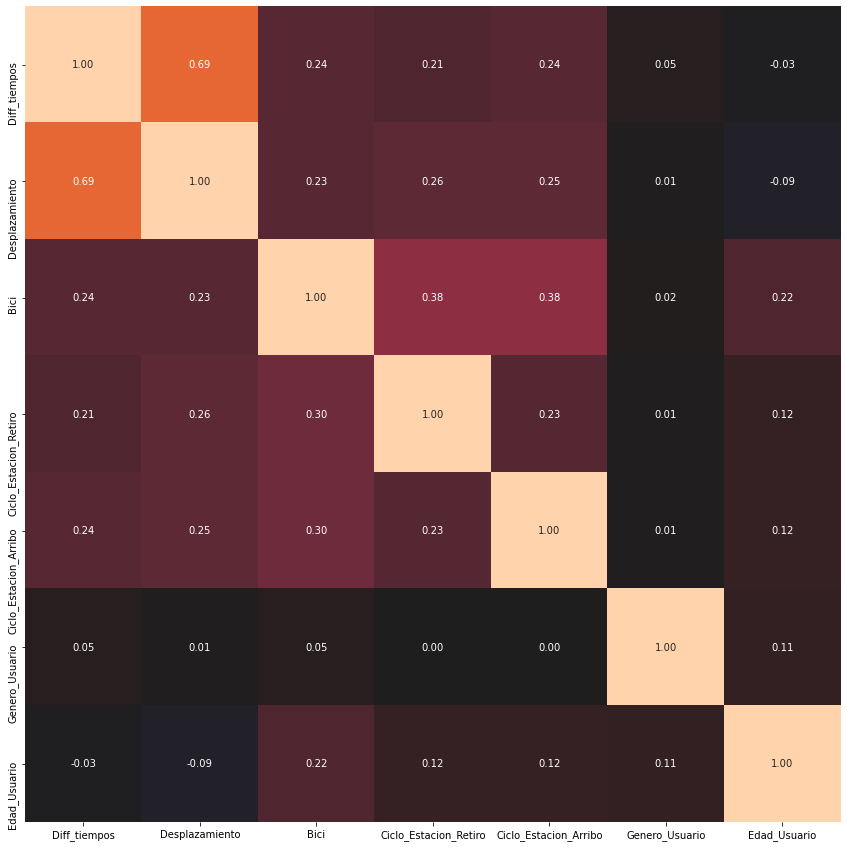

In [30]:
fig,axs = plt.subplots(figsize = (15,15))
diccionario_corr=associations(df19[["Genero_Usuario","Bici","Edad_Usuario", "Diff_tiempos","Desplazamiento","Ciclo_Estacion_Retiro","Ciclo_Estacion_Arribo"]],nominal_columns = ["Genero_Usuario", "Ciclo_Estacion_Retiro","Ciclo_Estacion_Arribo", "Bici"],ax = axs,  plot = True, clustering = True,nan_replace_value = -666, theil_u = True,cbar = False)
fig.suptitle("Correlaciones", fontsize = "xx-large")
fig.tight_layout()
plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/corrplot.jpg", bbox_inches ='tight')
plt.close(fig)

#### Jointplots

<Figure size 432x288 with 0 Axes>

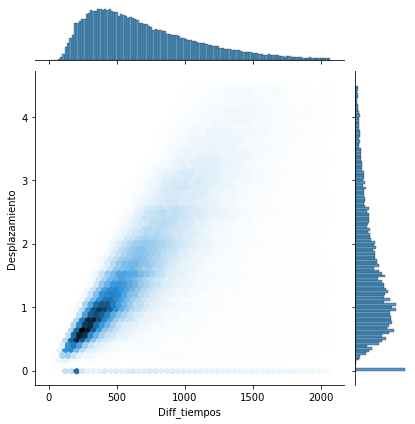

In [31]:
fig = plt.figure()
sns.jointplot(data = df19,
              x = df19["Diff_tiempos"], 
              y = df19["Desplazamiento"], 
              kind ="hex" )
plt.show()
plt.close(fig)

<Figure size 432x288 with 0 Axes>

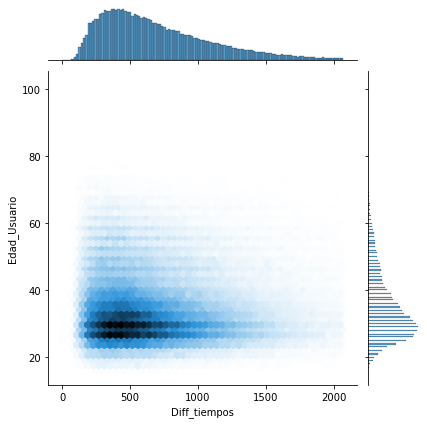

In [32]:
fig = plt.figure()
sns.jointplot(data = df19, 
              x = df19["Diff_tiempos"],
              y = df19["Edad_Usuario"], 
              kind ="hex" )
plt.show()
plt.close(fig)

<Figure size 432x288 with 0 Axes>

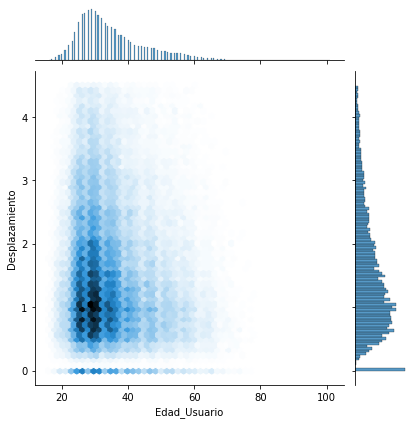

In [33]:
fig = plt.figure()
sns.jointplot(data = df19, 
              x = df19["Edad_Usuario"],
              y = df19["Desplazamiento"], 
              kind ="hex" )
plt.show()
plt.close(fig)

#### Histogramas

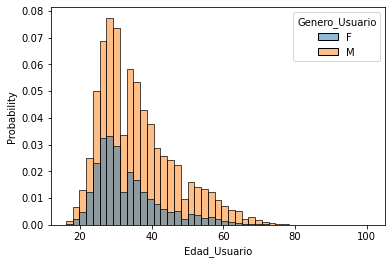

In [34]:
fig = plt.figure()
sns.histplot(data = df19, 
             x ="Edad_Usuario", 
             hue = "Genero_Usuario", 
             stat = "probability",
             common_norm= True, 
             bins = 45
    )
plt.show()
plt.close(fig)

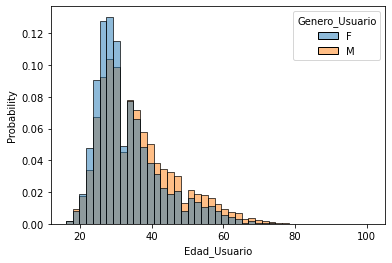

In [35]:
fig = plt.figure()
sns.histplot(data = df19, 
             x ="Edad_Usuario", 
             hue = "Genero_Usuario", 
             stat = "probability",
             common_norm= False, 
             bins = 45
    )
plt.show()

fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/H_Edad_hue_genero.jpg", bbox_inches ='tight')
plt.close(fig)

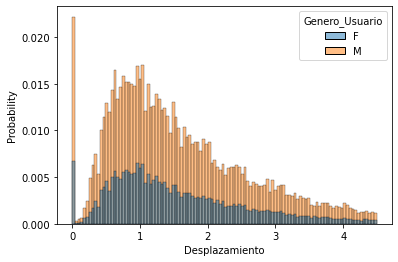

In [36]:
fig = plt.figure()
sns.histplot(data = df19, 
             x ="Desplazamiento", 
             hue = "Genero_Usuario",
             stat  = "probability",
             common_norm = True)
plt.show()
plt.close(fig)

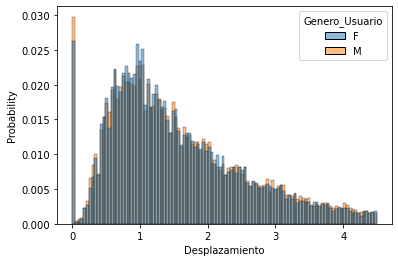

In [37]:
fig = plt.figure()
sns.histplot(data = df19, 
             x ="Desplazamiento", 
             hue = "Genero_Usuario",
             stat  = "probability",
             common_norm = False)
plt.show()
plt.title("Histograma Desplazamiento")
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/H_Desplazamiento_hue_genero.jpg", bbox_inches ='tight')
plt.close(fig)

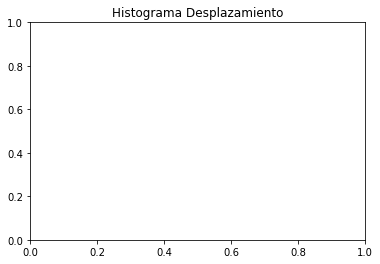

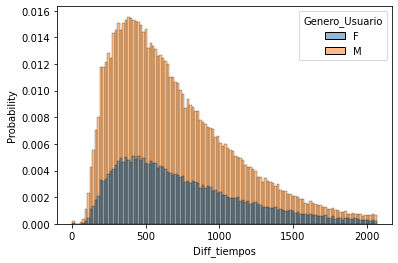

In [38]:
fig = plt.figure()
sns.histplot(data = df19, 
             x ="Diff_tiempos", 
             hue = "Genero_Usuario",
             stat  = "probability",
             common_norm = True)
plt.show()
plt.close(fig)

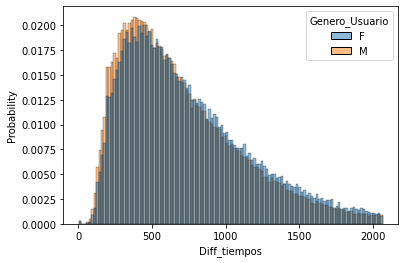

In [39]:
fig = plt.figure()
sns.histplot(data = df19, 
             x ="Diff_tiempos", 
             hue = "Genero_Usuario",
             stat  = "probability",
             common_norm = False)
plt.show()
plt.title("Histograma tiempos")
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/H_tiempos_hue_genero.jpg", bbox_inches ='tight')
plt.close(fig)

## Explorando tabla de frecuencias

#### Heatmap 

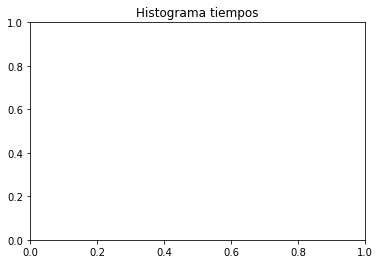

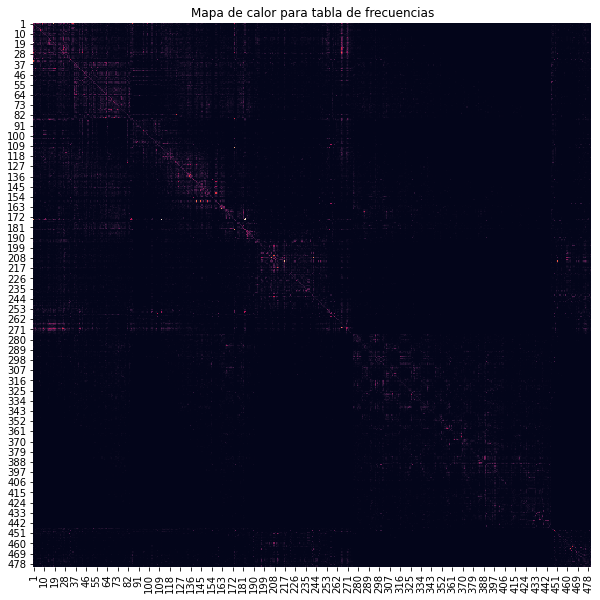

In [40]:
fig = plt.figure(figsize = (10,10))
sns.heatmap(tabla, cbar = False)
plt.title("Mapa de calor para tabla de frecuencias")
plt.show()

fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Estación_salida/Heatmap_tabla_frec.jpg", bbox_inches ='tight')
plt.close(fig)

#### Generando plots a partir de las distancias y las frecuencias

In [41]:
tabla

,1,2,3,4,5,6,7,8,9,10,...,471,472,473,474,475,476,477,478,479,480
1,65,30,12,48,53,29,32,2,82,16,...,5,0,2,5,6,14,5,1,0,4
2,35,33,2,5,6,11,8,1,46,2,...,0,0,0,0,1,0,0,0,0,0
3,13,11,13,6,9,9,15,2,14,1,...,0,0,4,1,0,0,4,3,0,1
4,51,5,2,24,2,9,4,0,0,4,...,1,0,2,1,5,0,1,1,0,1
5,48,5,0,10,22,3,16,1,7,0,...,3,0,0,7,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,8,1,2,2,0,4,5,0,6,2,...,8,0,6,6,13,13,6,9,0,4
477,2,1,1,3,0,0,2,3,2,0,...,2,0,2,3,2,1,5,8,0,3
478,3,4,0,2,1,6,15,0,3,1,...,2,0,1,0,1,16,14,6,0,5
479,0,0,0,0,0,0,0,0,0,0,...,0,12,0,0,0,0,0,0,10,0


In [42]:
for i in range(0,480):
    fig=plt.figure(figsize = (10,10))
    plt.scatter(mapa[:,0],
                mapa[:,1],
                c = tabla.loc[1+i,:].values[:],
               label = "Llegada")
    
    plt.scatter(mapa[i,0], 
                mapa[i,1],
                marker = "x", 
                s = 25, 
                c =  "red",
                alpha = 0.8,
               label = "Salida")
    plt.legend()
    plt.colorbar()
    fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Estación_salida/"+str(i+1)+".jpg", bbox_inches ='tight')
    plt.close(fig)

## Frecuencias máximas de ida para cada estación

In [43]:
maximos = np.zeros((480,3))
for i in range(1,481):
    indice=tabla.loc[i].idxmax()
    maximos [i-1,0]= i
    maximos [i-1,1]= indice
    maximos [i-1,2] = df_distancias.loc[i,indice]

In [44]:
Estaciones_maximas = np.unique(maximos[:,1]).astype("int")


In [45]:
print("Promedio: "+str(np.mean(maximos[:,2])))
print("")
print("Desviación estándar: "+str(np.std(maximos[:,2])))
print("")
print("Cuartiles: \n 25%: " 
      + str(np.percentile(maximos,25)) 
      +"\n 50%: "+str(np.percentile(maximos[:,2],50)) 
      + "\n 75%: "+ str(np.percentile(maximos[:,2],75))
     ) 

Promedio: 0.9233287959608387

Desviación estándar: 0.6759190094160885

Cuartiles: 
 25%: 1.1013676240741646
 50%: 0.806041941640145
 75%: 1.125808994629349


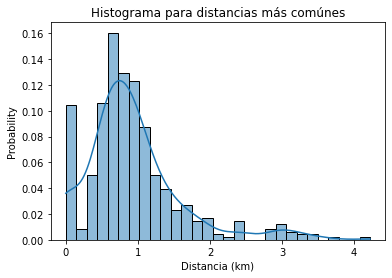

In [46]:
fig,ax = plt.subplots()
sns.histplot(x = maximos[:,2],
             stat  = "probability",
             kde = True,
             ax = ax)

ax.set_title("Histograma para distancias más comúnes")
ax.set_xlabel("Distancia (km)")
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/maxima_frecuencia_distancia.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

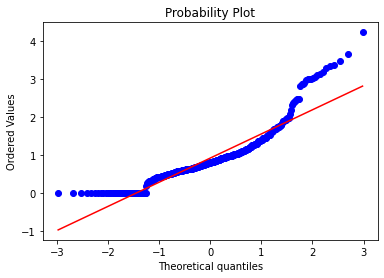

In [47]:
fig, ax = plt.subplots()
probplot(maximos[:,2], plot = ax)
plt.show()
plt.close(fig)

In [48]:
_,pvalue=lilliefors(maximos[:,2])
print("El valor P es: "+str(pvalue))

El valor P es: 0.0009999999999998899


### Estaciones más vistadas

In [49]:
Fml=tabla.sum()
Fms = tabla.sum(axis = 1)

In [50]:
print(Fml)
print(Fms)

1      2645
2       789
3       841
4       672
5       827
       ... 
476     897
477     379
478     323
479     169
480     467
Length: 480, dtype: int64
1      2576
2       891
3       938
4       581
5       810
       ... 
476     831
477     310
478     427
479     165
480     437
Length: 480, dtype: int64


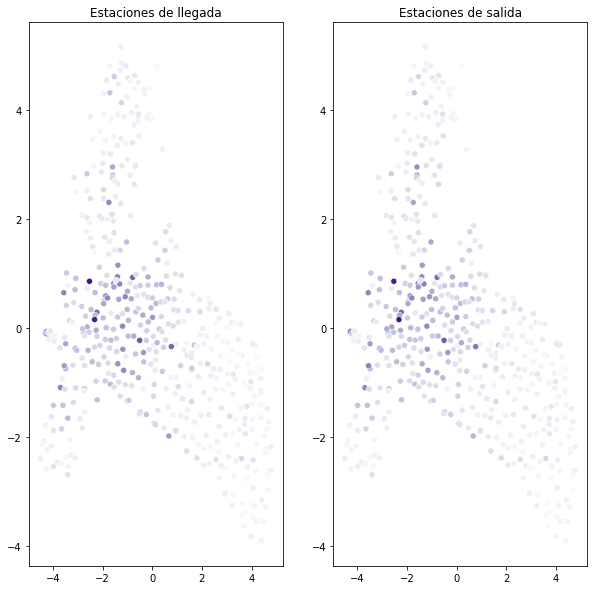

In [51]:
fig,axs= plt.subplots(1,2,figsize = (10,10))

sns.scatterplot(x= mapa[:,0],
                y= mapa[:,1], 
                c = Fml,
                cmap = sns.color_palette("Purples",as_cmap=True),
                ax = axs[0])
axs[0].set_title("Estaciones de llegada")

sns.scatterplot(x= mapa[:,0],
                y= mapa[:,1], 
                c = Fms,
                cmap = sns.color_palette("Purples",as_cmap=True),
                ax = axs[1])
axs[1].set_title("Estaciones de salida")


plt.show()
plt.close(fig)

## Clustering tabla de frecuencias

In [52]:
X = tabla.select_dtypes(include = np.number)
X=X.to_numpy()
X.shape

(480, 480)

In [53]:
X = preprocessing.scale(tabla)

#### TSNE

In [54]:
tsnep=TSNE(perplexity= 30,random_state = 666, init = "pca")
miso = tsnep.fit_transform(X)

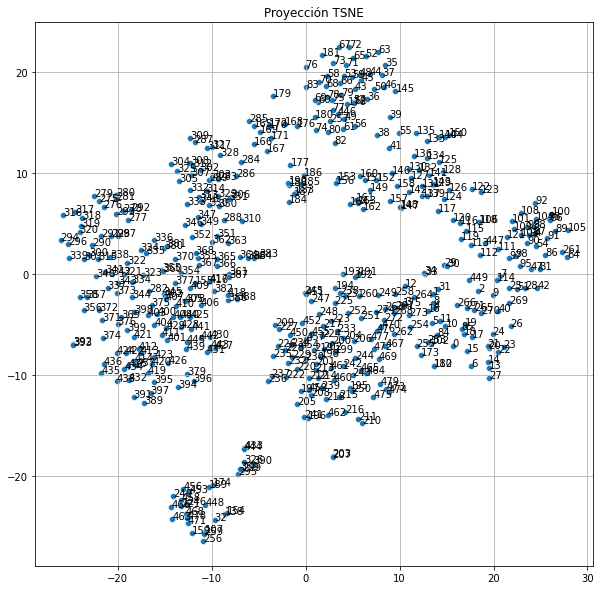

In [55]:
fig=plt.figure(figsize = (10,10))
plt.grid()
sns.scatterplot(data = miso,x = miso[:,0],y = miso[:,1])
contador = 0 
for i in range(0,480):
    plt.annotate(str(i), miso[i,:])
plt.title("Proyección TSNE")
plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/map plots/tsne.jpg", bbox_inches ='tight')
plt.close(fig)


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.42973316
For n_clusters = 3 The average silhouette_score is : 0.42906073
For n_clusters = 4 The average silhouette_score is : 0.45780995
For n_clusters = 5 The average silhouette_score is : 0.4816005
For n_clusters = 6 The average silhouette_score is : 0.46041998
For n_clusters = 7 The average silhouette_score is : 0.45802215
For n_clusters = 8 The average silhouette_score is : 0.4442234


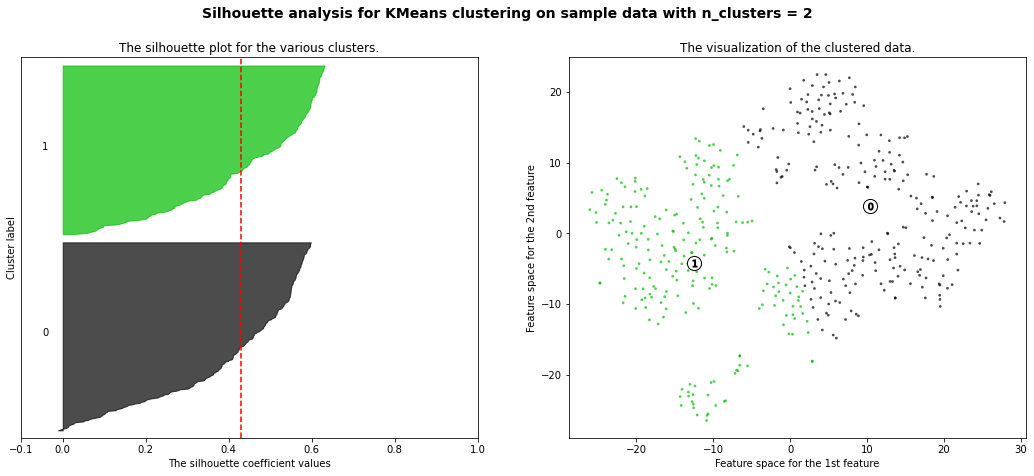

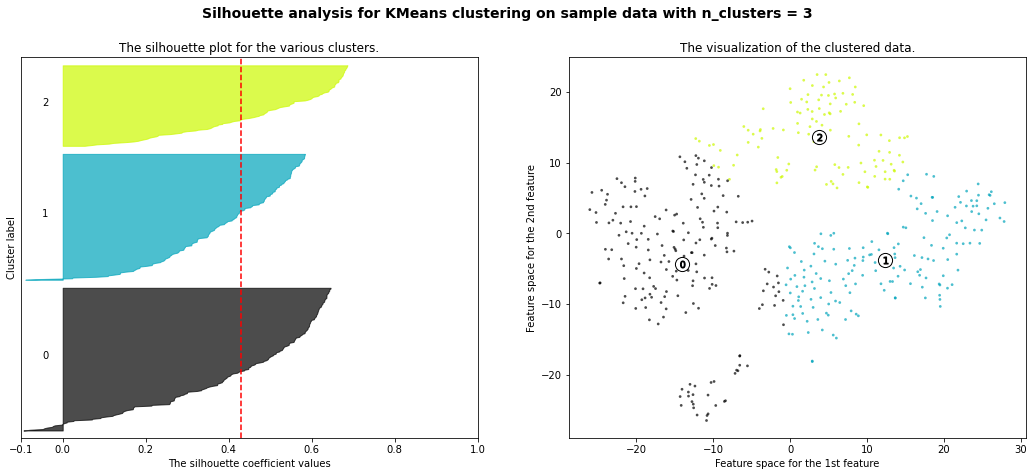

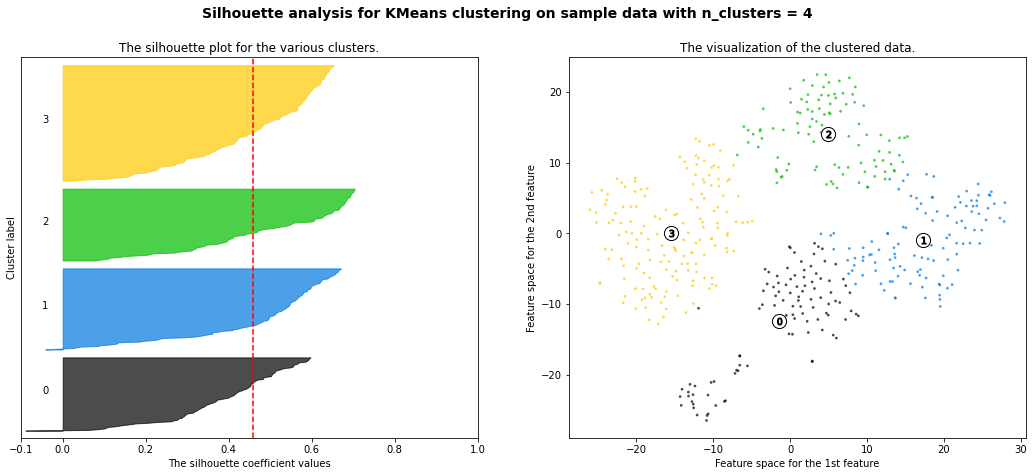

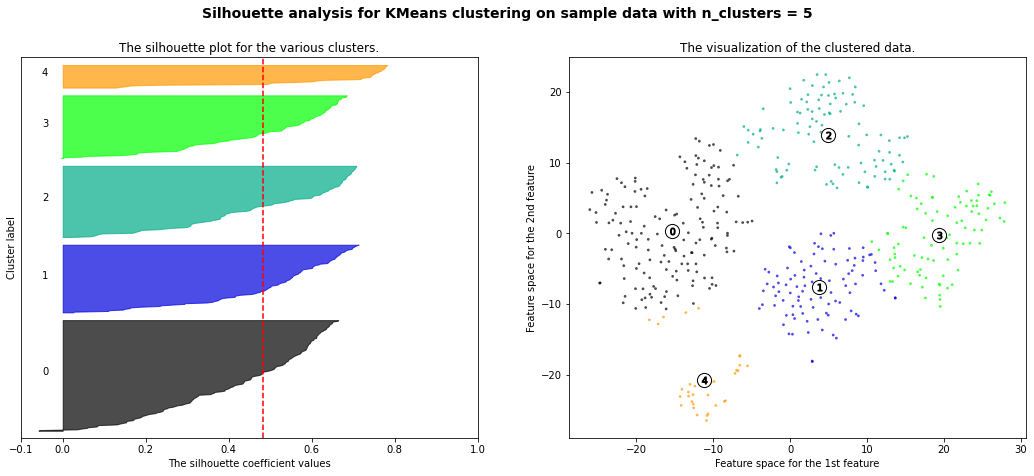

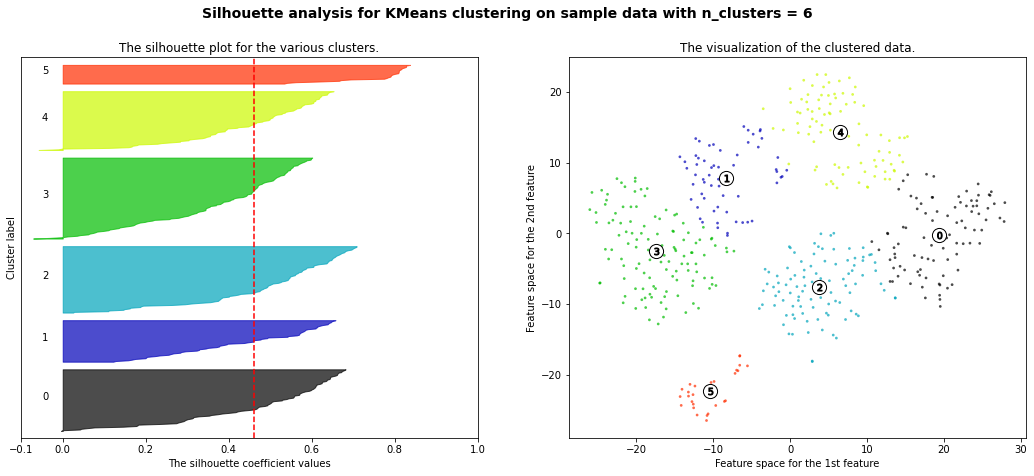

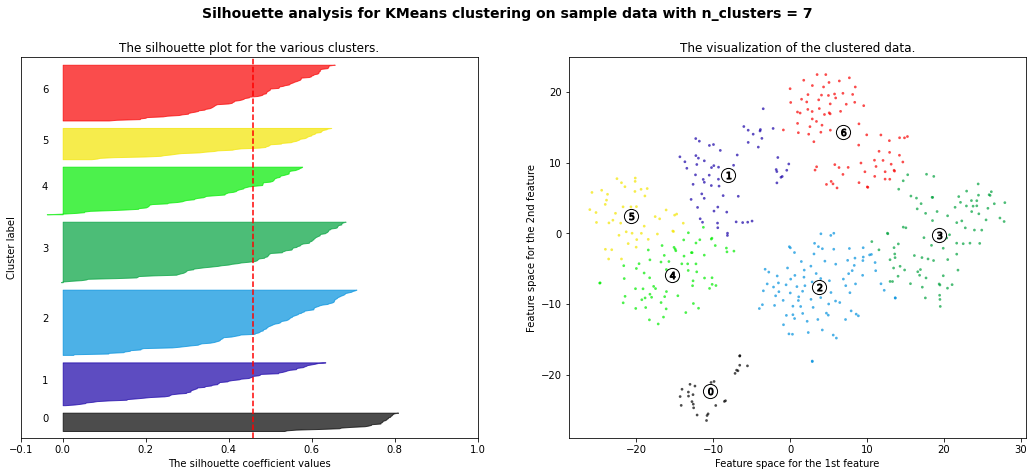

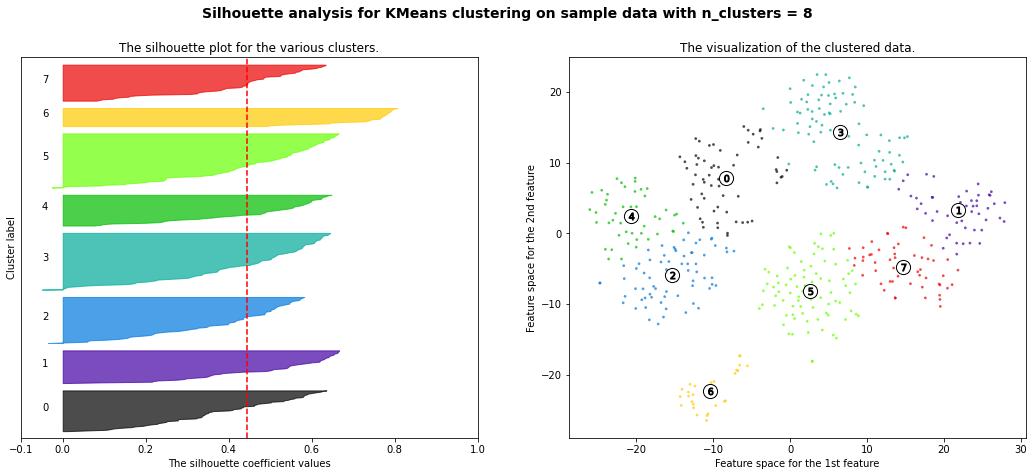

In [56]:
silueta(miso)

In [57]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(miso)
    distortions.append(kmeanModel.inertia_)

C:\Users\LENOVO\anaconda3\envs\keras\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


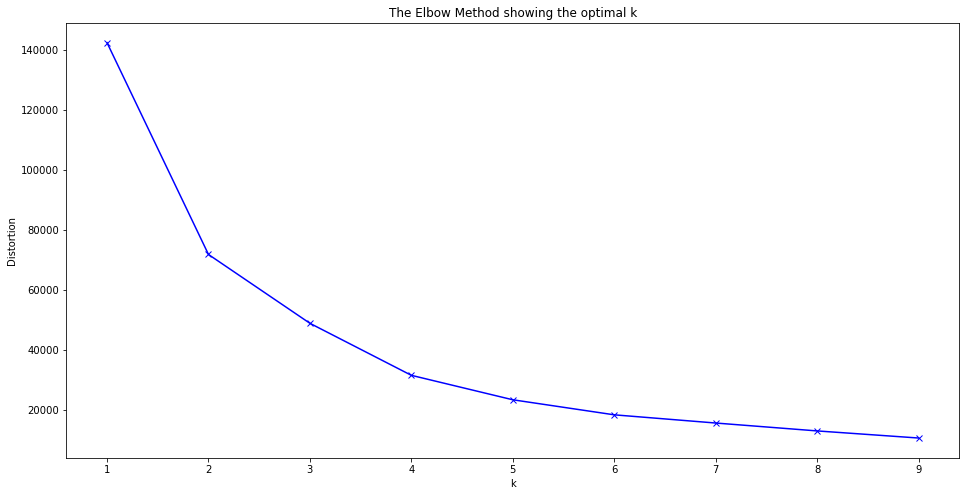

In [58]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### KMEANS

In [59]:
kmeanModel = KMeans(n_clusters=5, 
                    algorithm = "elkan")
kmeanModel.fit(miso)

KMeans(algorithm='elkan', n_clusters=5)

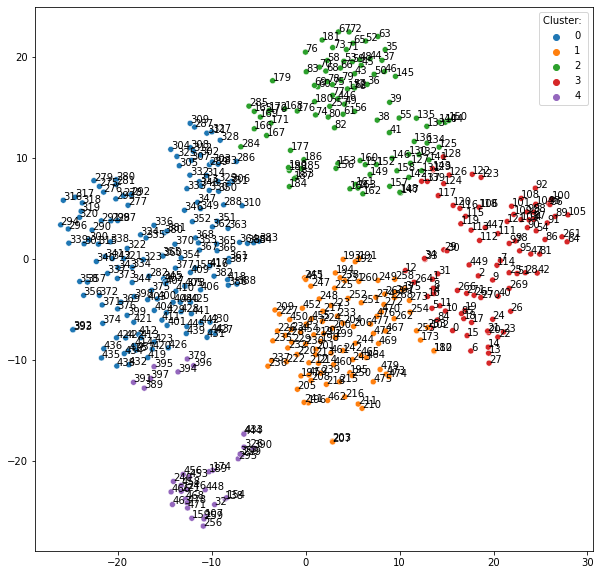

In [60]:
fig=plt.figure(figsize = (10,10))

sns.scatterplot(data = miso,x = miso[:,0],y = miso[:,1], hue =  kmeanModel.labels_,  palette=["C0", "C1", "C2","C3","C4"])
contador = 0 
for i in range(0,480):
    plt.annotate(str(i), miso[i,:])
plt.legend(title = "Cluster: ")
plt.show()
plt.close(fig)

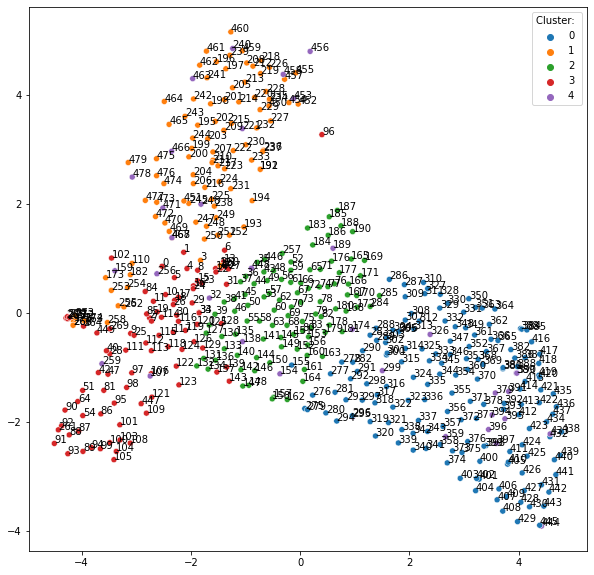

In [61]:
fig = plt.figure(figsize = (10,10))

sns.scatterplot(x= mapa[:,0],y= mapa[:,1],  hue =  kmeanModel.labels_,  palette=["C0", "C1", "C2","C3","C4"] )
#sns.scatterplot(x= mapa[Estaciones_maximas-1,0],y= mapa[Estaciones_maximas-1,1], color = "black" )
for i in range(0,480):
    plt.annotate(str(i), mapa[i,:])

plt.legend(title = "Cluster: ")
plt.show()
plt.close(fig)

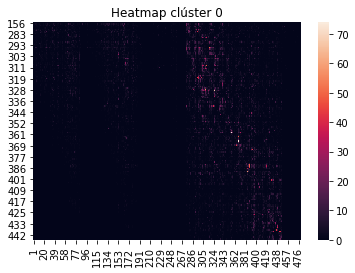

In [62]:
fig,axs = plt.subplots()
sns.heatmap(tabla[kmeanModel.labels_==0], ax= axs)
plt.title("Heatmap clúster 0")
plt.show()
plt.close(fig)

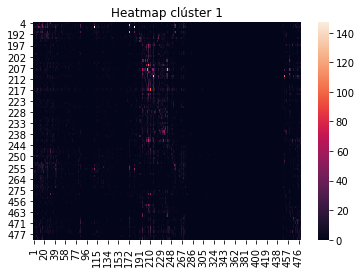

In [63]:
fig,axs = plt.subplots()
sns.heatmap(tabla[kmeanModel.labels_==1], ax= axs)
plt.title("Heatmap clúster 1")
plt.show()
plt.close(fig)

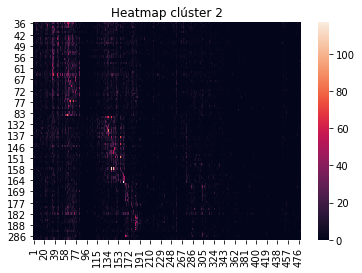

In [64]:
fig,axs = plt.subplots()
sns.heatmap(tabla[kmeanModel.labels_==2], ax= axs)
plt.title("Heatmap clúster 2")
plt.show()
plt.close(fig)

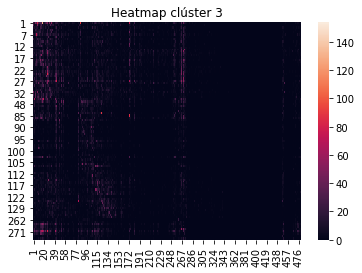

In [65]:
fig,axs = plt.subplots()
sns.heatmap(tabla[kmeanModel.labels_==3], ax= axs)
plt.title("Heatmap clúster 3")
plt.show()
plt.close(fig)

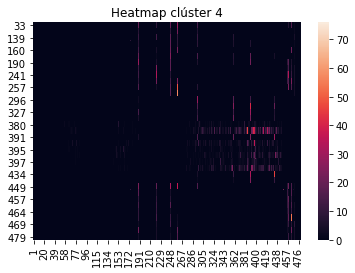

In [66]:
fig,axs = plt.subplots()
sns.heatmap(tabla[kmeanModel.labels_==4], ax= axs)
plt.title("Heatmap clúster 4")
plt.show()
plt.close(fig)

#### Fuzzy cmeans

In [67]:
cntr, u_orig, _, _, _, _, _ = cmeans(miso.T,5,2.1, error = 1e-5, maxiter = 200, seed = 666)

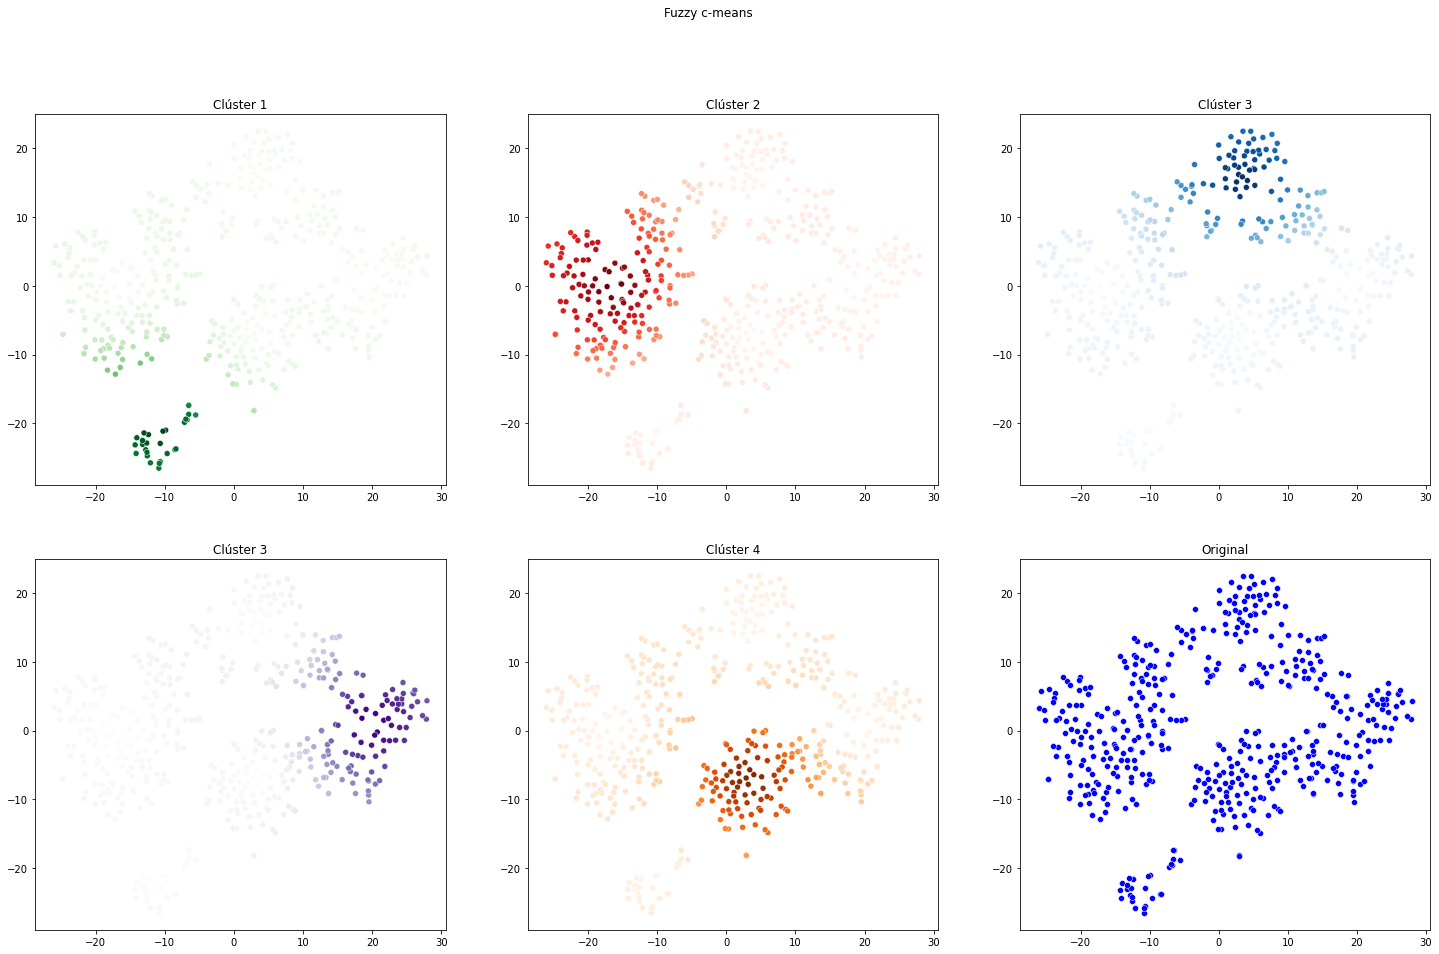

In [68]:
fig,axs = plt.subplots(nrows = 2, ncols =3, figsize = (25,15))



sns.scatterplot(ax = axs[0,0],
                data = miso, 
                x = miso[:,0], 
                y = miso[:,1], 
                c =u_orig[0,:], 
                cmap = sns.color_palette("Greens",as_cmap=True))

axs[0,0].set_title("Clúster 1")


sns.scatterplot(ax = axs[0,1],
                data = miso,
                x = miso[:,0],
                y = miso[:,1], 
                c = u_orig[1,:],
                cmap = sns.color_palette("Reds",as_cmap=True))
axs[0,1].set_title("Clúster 2")


sns.scatterplot(ax = axs[0,2], 
                data = miso, 
                x = miso[:,0], 
                y = miso[:,1],
                c = u_orig[2,:], 
                cmap =sns.color_palette("Blues",as_cmap=True) )
axs[0,2].set_title("Clúster 3")

sns.scatterplot(ax = axs[1,0],
                data = miso, 
                x = miso[:,0], 
                y = miso[:,1], 
                c =u_orig[3,:], 
                cmap = sns.color_palette("Purples",as_cmap=True))
axs[1,0].set_title("Clúster 3")


sns.scatterplot(ax = axs[1,1],
                data = miso,
                x = miso[:,0],
                y = miso[:,1], 
                c = u_orig[4,:],
                cmap = sns.color_palette("Oranges",as_cmap=True))
axs[1,1].set_title("Clúster 4")

sns.scatterplot(ax = axs[1,2],
                data =  miso,
                x =  miso[:,0],
                y =  miso[:,1], 
                color = "blue")
axs[1,2].set_title("Original")




plt.suptitle("Fuzzy c-means ")

fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/map plots/fuzzy_cmeans_TSNE.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

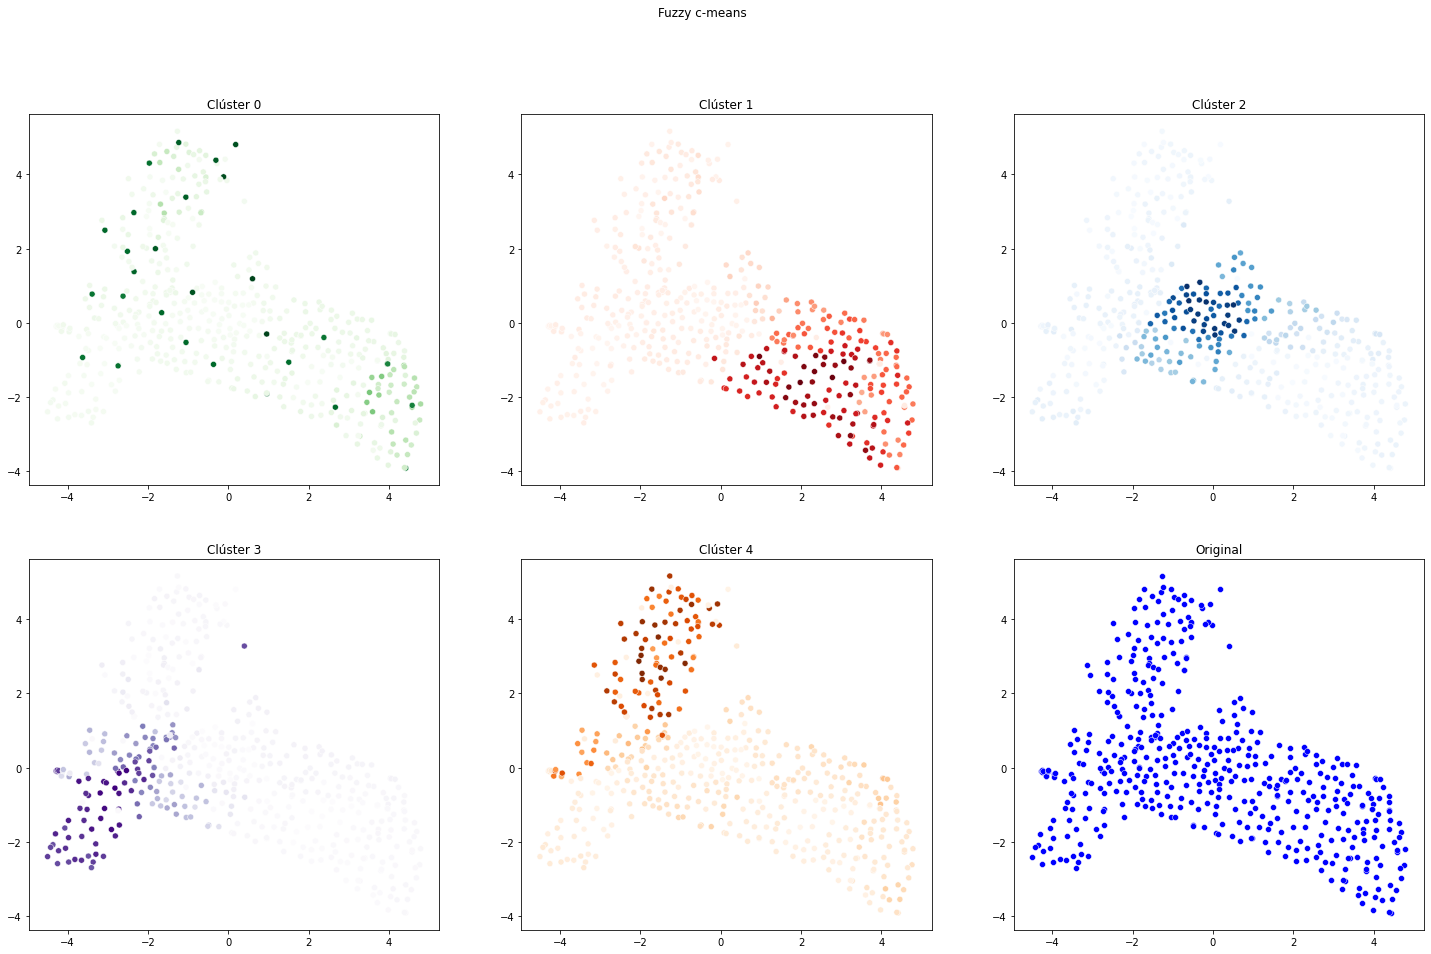

In [69]:
fig,axs = plt.subplots(nrows = 2, ncols =3, figsize = (25,15))



sns.scatterplot(ax = axs[0,0],
                data = mapa, 
                x = mapa[:,0], 
                y =  mapa[:,1], 
                c =u_orig[0,:], 
                cmap = sns.color_palette("Greens",as_cmap=True))
axs[0,0].set_title("Clúster 0")


sns.scatterplot(ax = axs[0,1],
                data = mapa,
                x =  mapa[:,0],
                y =  mapa[:,1], 
                c = u_orig[1,:],
                cmap = sns.color_palette("Reds",as_cmap=True))
axs[0,1].set_title("Clúster 1")


sns.scatterplot(ax = axs[0,2], 
                data =  mapa, 
                x =  mapa[:,0], 
                y =  mapa[:,1],
                c = u_orig[2,:], 
                cmap =sns.color_palette("Blues",as_cmap=True) )
axs[0,2].set_title("Clúster 2")

sns.scatterplot(ax = axs[1,0],
                data =  mapa, 
                x =  mapa[:,0], 
                y =  mapa[:,1], 
                c =u_orig[3,:], 
                cmap = sns.color_palette("Purples",as_cmap=True))
axs[1,0].set_title("Clúster 3")


sns.scatterplot(ax = axs[1,1],
                data =  mapa,
                x =  mapa[:,0],
                y =  mapa[:,1], 
                c = u_orig[4,:],
                cmap = sns.color_palette("Oranges",as_cmap=True))
axs[1,1].set_title("Clúster 4")

sns.scatterplot(ax = axs[1,2],
                data =  mapa,
                x =  mapa[:,0],
                y =  mapa[:,1],
                color = "blue"
                )
axs[1,2].set_title("Original")




plt.suptitle("Fuzzy c-means ")

fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/map plots/tSNE_MAPS_REAL.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

In [70]:
fuzzy_labels = np.argmax(u_orig, axis=0)


In [71]:
df19["Clúster"] = df19.apply(lambda row: fuzzy_labels[row["Ciclo_Estacion_Arribo"]-1], axis = 1 )

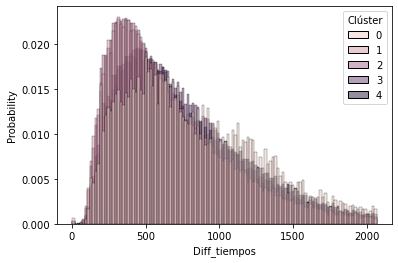

In [72]:

fig = plt.figure()
sns.histplot(data = df19, 
             x ="Diff_tiempos", 
             hue = "Clúster", 
             stat = "probability",
             common_norm= False,
             common_bins = True )

plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/H_fuzzy_cmeans_tiempos.jpg", bbox_inches ='tight')
plt.close(fig)

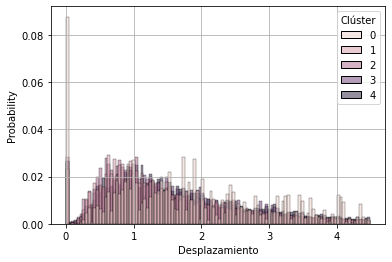

In [73]:
fig = plt.figure()
plt.grid()
sns.histplot(data = df19,
             x = "Desplazamiento", 
             hue = "Clúster",
            stat = "probability",
            common_norm = False,
            common_bins = True)
plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Histograms/H_fuzzy_cmeans_Desplazamiento.jpg", bbox_inches ='tight')
plt.close(fig)

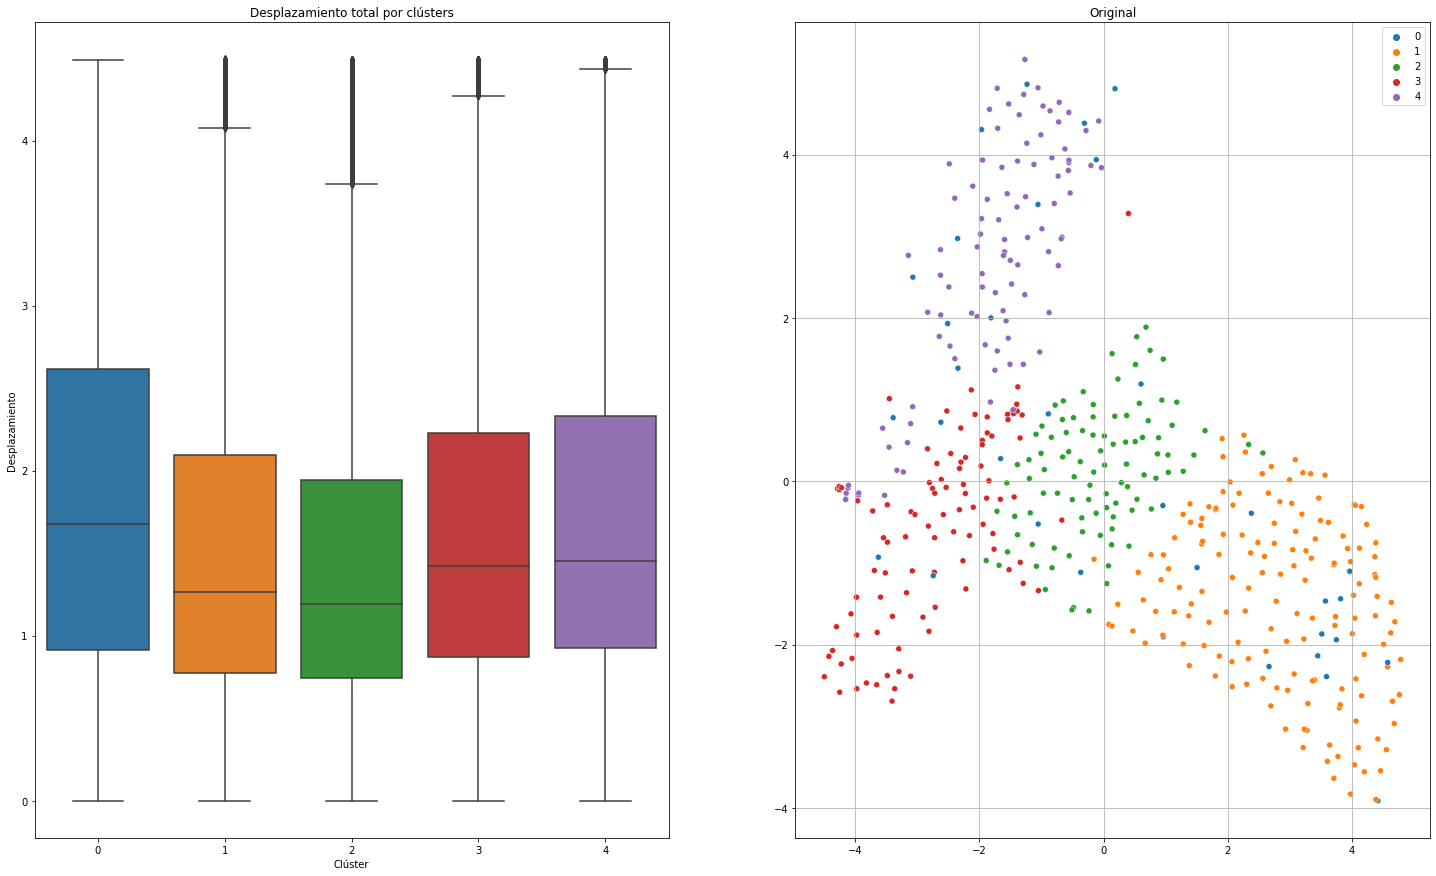

In [74]:
fig,axs  = plt.subplots(1,2, figsize = (25,15))
plt.grid()
sns.boxplot(data = df19,
            x = "Clúster",
             y = "Desplazamiento", 
            ax = axs[0])
axs[0].set_title("Desplazamiento total por clústers")

sns.scatterplot(ax = axs[1],
                 x= mapa[:,0],
                y= mapa[:,1], 
                hue =  fuzzy_labels, 
                palette=["C0", "C1", "C2","C3","C4"]
                )
axs[1].set_title("Original")


plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Boxplot/fuzzy_cmeans_Desplazamiento.jpg", bbox_inches ='tight')
plt.close(fig)

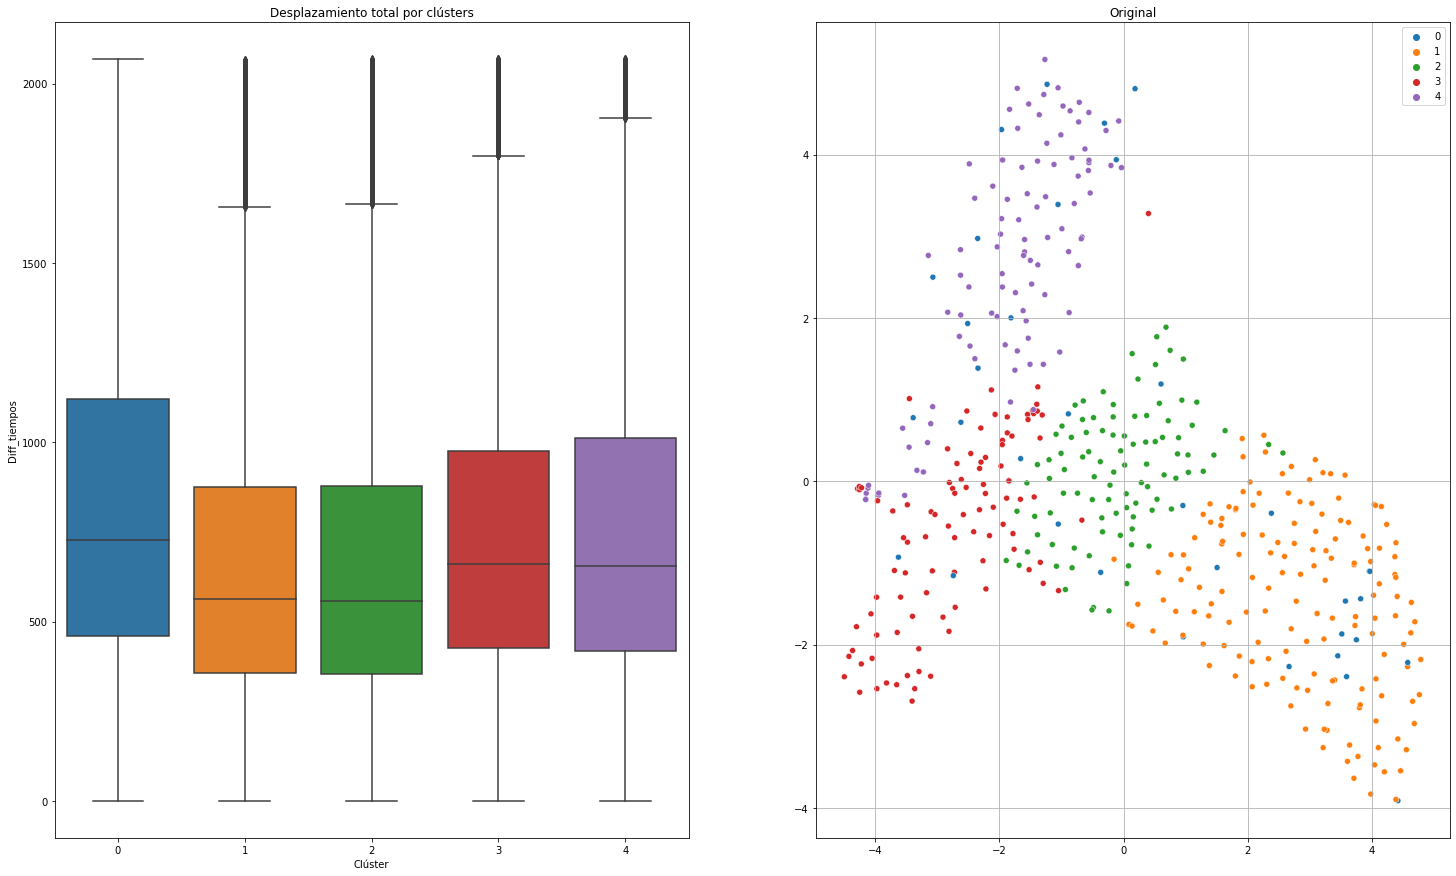

In [75]:
fig,axs  = plt.subplots(1,2, figsize = (25,15))
plt.grid()
sns.boxplot(data = df19,
            x = "Clúster",
             y = "Diff_tiempos", 
            ax = axs[0])
axs[0].set_title("Desplazamiento total por clústers")

sns.scatterplot(ax = axs[1],
                 x= mapa[:,0],
                y= mapa[:,1], 
                hue =  fuzzy_labels, 
                palette=["C0", "C1", "C2","C3","C4"]
                )
axs[1].set_title("Original")


plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Boxplot/fuzzy_cmeans_Diff_tiempos.jpg", bbox_inches ='tight')
plt.close(fig)

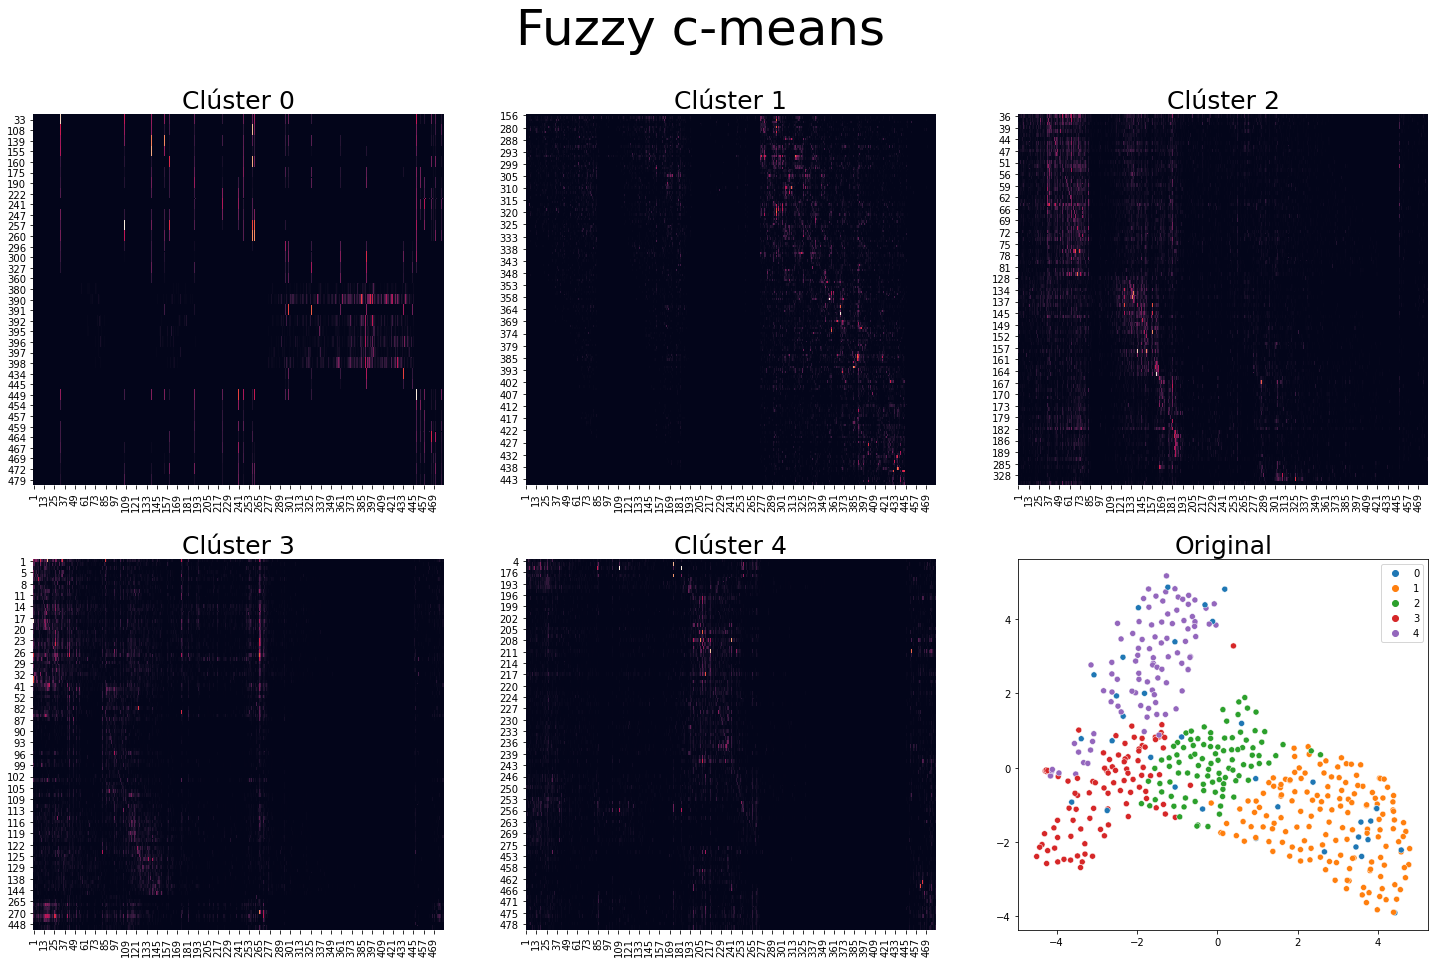

In [76]:
fig,axs = plt.subplots(nrows = 2, ncols =3, figsize = (25,15))



sns.heatmap(ax = axs[0,0],
            data  =tabla[fuzzy_labels == 0], 
            cbar = False)
axs[0,0].set_title("Clúster 0",fontsize=25)

sns.heatmap(ax = axs[0,1],
            data  =tabla[fuzzy_labels == 1],
            cbar = False)
axs[0,1].set_title("Clúster 1",fontsize=25)


sns.heatmap(ax = axs[0,2], 
            data  =tabla[fuzzy_labels == 2],
            cbar = False)
axs[0,2].set_title("Clúster 2",fontsize=25)

sns.heatmap(ax = axs[1,0],
            data  =tabla[fuzzy_labels == 3],
            cbar = False)
axs[1,0].set_title("Clúster 3",fontsize=25)


sns.heatmap(ax = axs[1,1],
            data  =tabla[fuzzy_labels == 4],
            cbar = False)
axs[1,1].set_title("Clúster 4",fontsize=25)


sns.scatterplot(ax = axs[1,2],
                x= mapa[:,0],
                y= mapa[:,1], 
                hue =  fuzzy_labels, 
                palette=["C0", "C1", "C2","C3","C4"] )
axs[1,2].set_title("Original",fontsize=25)




plt.suptitle("Fuzzy c-means ",fontsize=50)

fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/Heatmaps/fuzzy_cmeans_heatmap.jpg", bbox_inches ='tight')
plt.show()
plt.close(fig)

#### Countmap

In [77]:
Fml["Clúster"] = fuzzy_labels

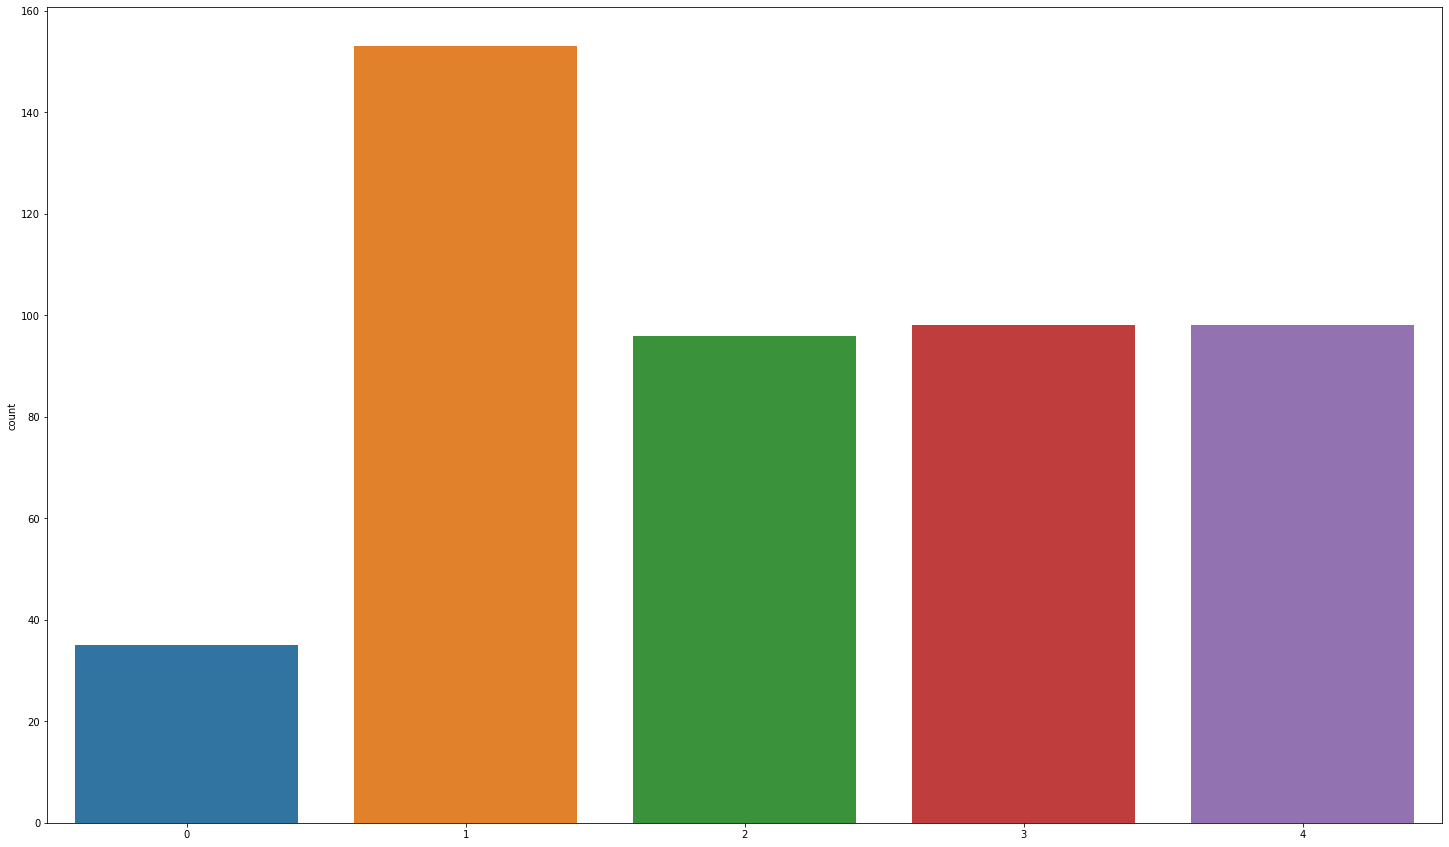

In [78]:
fig = plt.figure(figsize = (25,15))
sns.countplot(data = Fml, x = "Clúster")
plt.show()

plt.close(fig)

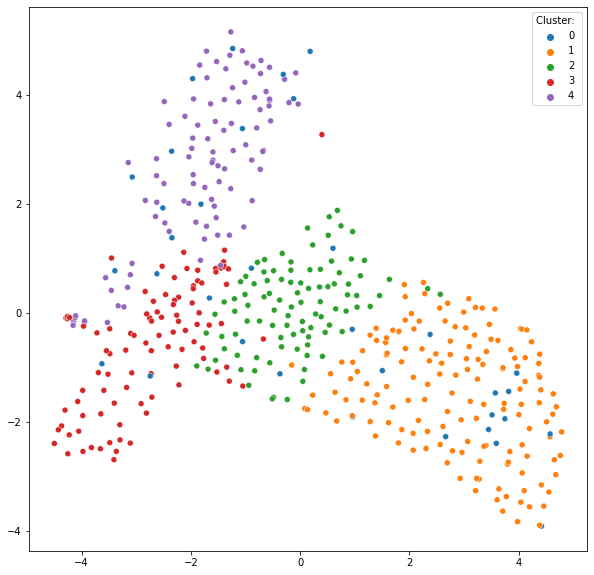

In [79]:
fig = plt.figure(figsize = (10,10))

sns.scatterplot(x= mapa[:,0],
                y= mapa[:,1], 
                hue =  fuzzy_labels, 
                palette=["C0", "C1", "C2","C3","C4"] )



plt.legend(title = "Cluster: ")
plt.show()
fig.savefig("C:/Users/LENOVO/Desktop/Clases/Matematicas 2/Github/Proyecto-mate/Imagenes/map plots/cluster_fuzz_maps.jpg", bbox_inches ='tight')
plt.close(fig)